## Abstract

In this blog post, I implement the Perceptron algorithm from scratch in Python. The Perceptron algorithm is a simple algorithm for learning a binary classifier. It is the simplest type of artificial neural network. It is a model of a single neuron that can be used for two-class classification problems. The Perceptron algorithm is a linear classifier, which means it can only be used for linearly separable data. We find that it does not work well on non-linearly separable data. We implement a Mini-batch Perceptron algorithm to improve the convergence speed of the Perceptron algorithm and to better deal with non-linearly separable data. We perform various experiments to evaluate the performance of the Perceptron algorithm and the Mini-batch Perceptron algorithm on synthetic datasets and real-world datasets. We find that the Mini-batch Perceptron algorithm converges faster than the Perceptron algorithm and is more robust to non-linearly separable data.

## Part A: Implement Perceptron

In this section of the blog post, I will be implementing the Perceptron algorithm from scratch. The Perceptron algorithm is a type of linear classifier, which is used to classify data points into one of two classes. The algorithm works by finding a hyperplane that separates the data points into two classes. The hyperplane is defined by a set of weights and a bias term. The weights are used to determine the orientation of the hyperplane, while the bias term is used to determine the position of the hyperplane in the feature space.

The Perceptron algorithm works by iteratively updating the weights and bias term in order to minimize the classification error. The algorithm starts with an initial set of weights and bias term, and then iterates over the training data points. For each data point, the algorithm computes the predicted class label based on the current weights and bias term, and then updates the weights and bias term based on the error between the predicted class label and the true class label.

The Perceptron algorithm is a simple and efficient algorithm for binary classification tasks. It is a type of online learning algorithm, which means that it updates the weights and bias term based on each data point in the training set. The algorithm is guaranteed to converge if the data is linearly separable, and it can be extended to handle non-linearly separable data by using a kernel function.

In the following sections, I will implement the Perceptron algorithm in Python and test it on a synthetic dataset. I will also visualize the decision boundary learned by the Perceptron algorithm to see how well it separates the data points into two classes.

Let's get started by implementing the Perceptron algorithm in Python.

This is done in [perceptron.py](./perceptron.py) file. I will not cover the entirety of the coding file, but will touch on the `perceptron.grad()` portion of the code:

In [ ]:
# grad() function from perceptron.py

def grad(self, X, y):
       # Computes the vector to add to the weights to minimize the loss
       s = X@self.w
       return (s*y < 0)*X*y

In the first line of `grad()` function, we calculate the inner product:

$s_i = \langle \mathbf{w}^{(t)}, \mathbf{x}_i \rangle$

`X` and `self.w` are used to compute this inner product with the `@` operator from `torch`

In the final line of the `grad()` function we use the result from the first line to calculate:

$[s_i y_i < 0] y_i \mathbf{x}_i$

With that said, let's begin testing our implementation

In order to test the implementation, I will run the "minimal training loop". We need some data to first test this on, so below we will implement some testing data.

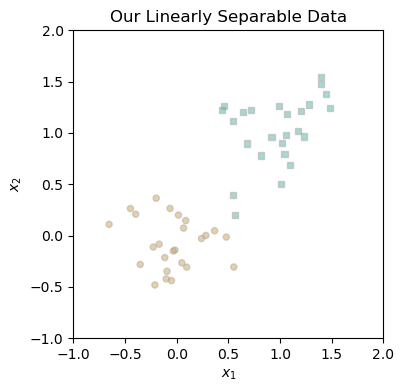

In [8]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer
import torch
from matplotlib import pyplot as plt

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

# define function to plot data
def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

# set seed
torch.manual_seed(1234)

# create linearly separable data
X_ls, y_ls = perceptron_data(n_points = 50, noise = 0.3)

# plot linearly separable data
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X_ls, y_ls, ax)
ax.set_title("Our Linearly Separable Data");

With our data generated, we can now test the Perceptron algorithm by running the minimal training loop. From what we have seen so far, there is a clear separation between the two classes, so the Perceptron algorithm should be able to learn a decision boundary that separates the data points into two classes. Let's run the minimal training loop and visualize the decision boundary learned by the Perceptron algorithm.

In [27]:
# set seed
torch.manual_seed(1234567)

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X_ls, y_ls) 
    loss_vec.append(loss)
    
    # perform a perceptron update using the random data point
    opt.step(X_ls, y_ls)

We can track the progress of our training by checking the values of the loss function over time:

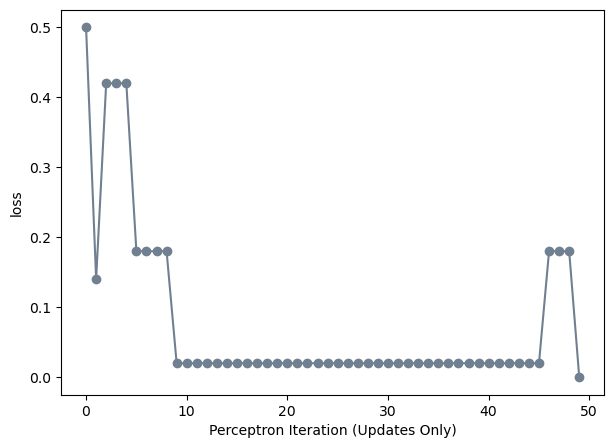

In [28]:
#| label: fig-line-pep-loss
#| fig-cap: Loss as a function of the number of perceptron updates

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

From this, we can see that training completed with the achievement of zero loss; that is, perfect training accuracy. With this in mind, we can now move on to the next section of the blog post, where we will implement the Perceptron algorithm further. 

## Part B: Experiments 

With a functional implementation of the perceptron algorithm, we can now move on to the next section of the blog post, where we will experiment with the algorithm. 

# Part 1B: Using Linearly Separable Data

As seen with @fig-line-pep-loss, the perceptron algorithm converges to a solution with zero loss after 49 iterations. For 43 of the 49 iterations, the loss did not change, meaning that the randomly selected point was correctly classified by the model at that iteration.

Using the figure below created by Professor Chondrow of Middlebury College, we can see that the perceptron algorithm is able to learn a decision boundary that separates the data points into two classes. 

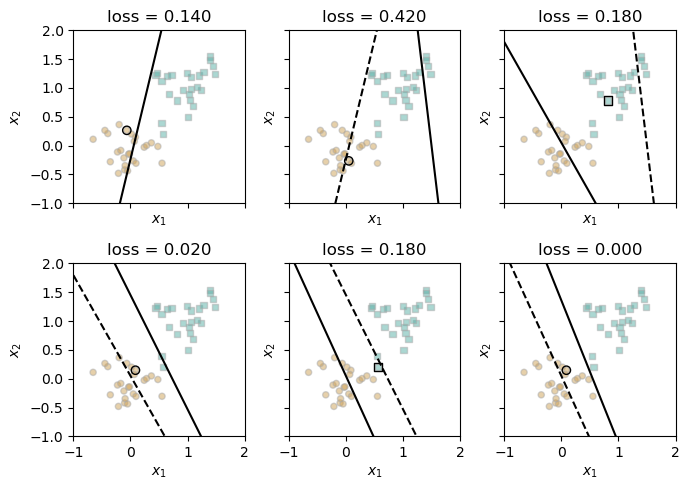

In [29]:
# define line function
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X_ls, y_ls)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

while loss > 0:
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 
    i, local_loss = opt.step(X_ls, y_ls)

    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if local_loss > 0:
        plot_perceptron_data(X_ls, y_ls, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X_ls, y_ls).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X_ls[i,0],X_ls[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[y_ls[i].item()]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
plt.tight_layout()

These figures show the decision boundary learned by the Perceptron algorithm after each iteration. The decision boundary is represented by a line that separates the data points into two classes. The dotted line represents the previous decision boundary, while the solid line represents the new decision boundary learned by the Perceptron algorithm. As we can see, the decision boundary changes after each iteration as the Perceptron algorithm updates the weights and bias term to minimize the classification error.

# Part 2B: Using Non-Linearly Separable Data

When the data is not linearly separable, the perceptron algorithm will not settle on a final value of `w`, but will instead run until the maximum number of iterations is reached, without achieving perfect accuracy.

In this section we will visualize the decision boundary learned by the Perceptron algorithm on non-linearly separable data. We will generate a synthetic dataset that is not linearly separable, and then run the Perceptron algorithm on the dataset to see how well it separates the data points into two classes. To ensure that the algorithm terminates in a reasonable amount of time, we will set a maximum number of iterations.

In order to create our non-linearly separable data, we will use the same method to generate our linearly separable data, but we will add some noise to the data points. This will make it more difficult for the Perceptron algorithm to learn a decision boundary that separates the data points into two classes.

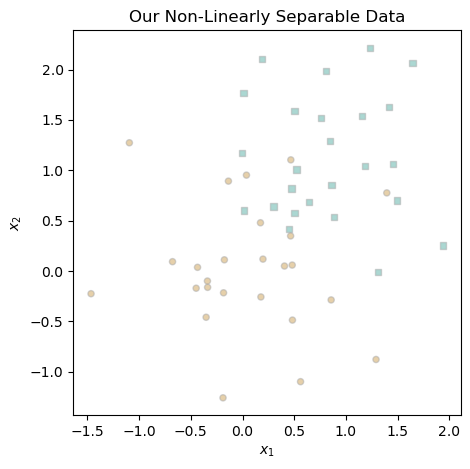

In [31]:
# set seed
torch.manual_seed(2409)

# create non-linearly separable data
X_nls, y_nls = perceptron_data(n_points = 50, noise = 0.65)

# plot non-linearly separable data
fig, ax = plt.subplots(figsize = (5, 5))
plot_perceptron_data(X_nls, y_nls, ax)
ax.set_title("Our Non-Linearly Separable Data");

With adding noise we can see that the classes are no longer linearly separable. This means that the Perceptron algorithm will not be able to find a decision boundary that perfectly separates the data points into two classes. Instead, the algorithm will run until the maximum number of iterations is reached, without achieving perfect accuracy.

Let's try to fit this data using the Perceptron algorithm and visualize the decision boundary learned by the algorithm. We will set a maximum number of iterations to ensure that the algorithm terminates in a reasonable amount of time.

In [33]:
torch.manual_seed(1234567)

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

# define loss variable
loss = 1.0

# for keeping track of loss values
loss_vec = []

# for recording iteration number
iter = 0

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X_nls, y_nls) 
    loss_vec.append(loss)
    
    # perform a perceptron update using the random data point
    opt.step(X_nls, y_nls)

    # set maximum number of iterations
    iter += 1

    if iter >= 1000:
        break

This is the same code as before, just with the addition of a maximum iteration count. Let's visualize the change in loss over the iterations:

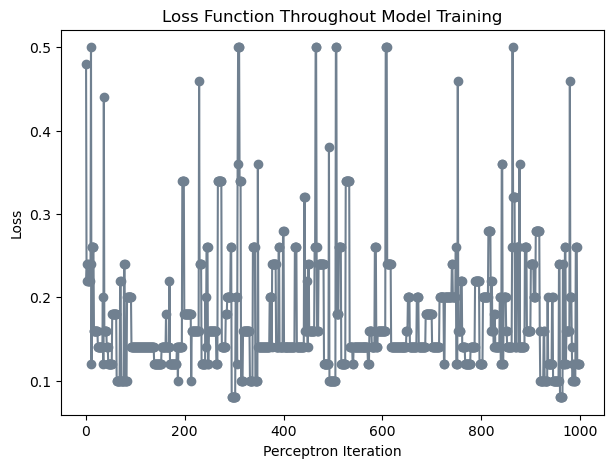

In [34]:
# plot the changes in loss 
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration", ylabel = "Loss")
plt.title("Loss Function Throughout Model Training");

As expected, due to the noise in the data, the Perceptron algorithm does not converge to a solution with zero loss. Instead, the algorithm runs until the maximum number of iterations is reached, without achieving perfect accuracy. The decision boundary learned by the Perceptron algorithm is not able to perfectly separate the data points into two classes, but it does a reasonable job of separating the data points.

Due to the sheer amount of changes in weights, we will look at the final decision boundary created by the Perceptron algorithm on this data set.

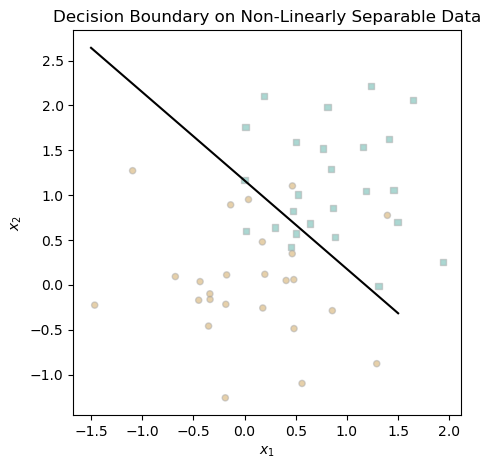

In [35]:
# Plot final decision boundary
fig, ax = plt.subplots(figsize = (5, 5))
plot_perceptron_data(X_nls, y_nls, ax)
draw_line(p.w, x_min = -1.5, x_max = 1.5, ax = ax, color = "black")
ax.set_title("Decision Boundary on Non-Linearly Separable Data");

Again, as expected the decision boundary learned by the Perceptron algorithm does not perfectly separate the data points into two classes, but it does a reasonable job of separating the data points. This limitation of the Perceptron algorithm is due to the fact that it is a linear classifier, and can only learn linear decision boundaries. In order to handle non-linearly separable data, we would need to use a more complex classifier, such as a support vector machine or a neural network.

# Part 3B: More Than 2 Dimensions!

We have seen the model trained on 2-dimensional data. However, the Perceptron algorithm can be extended to handle data with more than two dimensions. In this section, we will generate a synthetic dataset with five dimensions, and then run the Perceptron algorithm on the dataset to see how well it separates the data points into two classes.

In [36]:
# set seed
torch.manual_seed(1234)

# create data
X_5d, y_5d = perceptron_data(n_points = 50, noise = 0.3, p_dims = 5)

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

# define loss variable
loss = 1.0

# for keeping track of loss values
loss_vec = []

# for recording iteration number
iter = 0

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X_5d, y_5d) 
    loss_vec.append(loss)
    
    # perform a perceptron update using the random data point
    opt.step(X_5d, y_5d)

    iter += 1
    if iter >= 1000:
        break

We cannot visualize the decision boundary in five dimensions, but we can still test the Perceptron algorithm on the dataset and see how well it performs. Let's inspect the changes to our loss function over time using the same plot we used before:

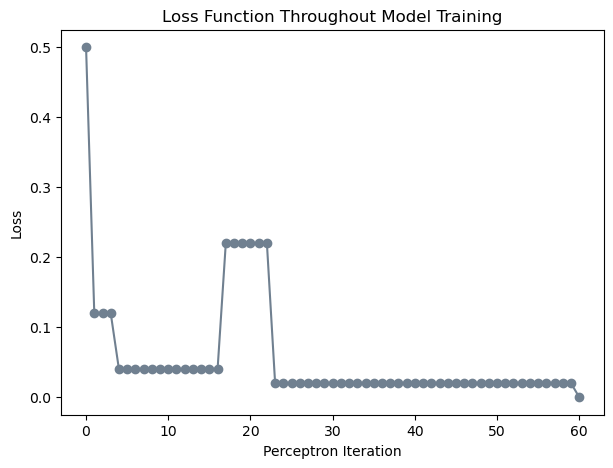

In [37]:
# plot the changes in loss 
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration", ylabel = "Loss")
plt.title("Loss Function Throughout Model Training");

We observe that the algorithm terminated after 6o iterations, with a loss of 0. This means that the Perceptron algorithm was able to learn a decision boundary that separates the data points into two classes in five dimensions. This demonstrates that the Perceptron algorithm can be extended to handle data with more than two dimensions, and can learn a decision boundary that separates the data points into two classes in higher-dimensional feature spaces as long as the training data is linearly separable.

## Part C: MiniBatch Perceptron 

In this section of the blog post, I will be implementing the MiniBatch Perceptron algorithm from scratch. The MiniBatch Perceptron algorithm is a variant of the Perceptron algorithm that updates the weights and bias term based on a mini-batch of data points, rather than updating the weights and bias term based on each data point in the training set. This can lead to faster convergence and better generalization performance, especially when the training data is large.

Mathematically, the MiniBatch Perceptron algorithm works as follows:

1. Randomly select an initial decision boundary $\mathbf{w}^{(0)}$
2. Iteratively:
    
    Sample $k$ random integers $i_1, i_2, ..., i_k \in \{1,\ldots,n\}$ without replacement.
    
    Update the decision boundary:
    
    $\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} + \frac{\alpha}{k} \sum_{j=1}^k \mathbb{1} [\langle \mathbf{w}^{(t)}, \mathbf{x}_{i_j} \rangle y_{i_j} < 0] y_{i_j} \mathbf{x}_{i_j}$


My implementation can be found at [minibatch_perceptron.py](./minibatch_perceptron.py). Fitting the MiniBatch perceptron model is the same as the normal perceptron model just with the addition of $k$ and $\alpha$ as hyperparameters. 

The $k$ paramater represents the number of data points to sample in each iteration, while the $\alpha$ parameter represents the learning rate of the algorithm. The learning rate controls how much the weights and bias term are updated in each iteration. A higher learning rate will result in larger updates to the weights and bias term, while a lower learning rate will result in smaller updates.

We will perform 3 experiments, `C1`, `C2`, and `C3` to test the MiniBatch Perceptron algorithm on different datasets.

Let's begin by defining the experiment code for all of the experiments:

In [45]:
from minibatch_perceptron import MiniBatchPerceptron, MiniBatchPerceptronOptimizer

def experiment(X, y, k, alpha):  
    # set seed
    torch.manual_seed(1234567)

   # MiniBatch Perceptron
    mb_p = MiniBatchPerceptron() 
    mb_opt = MiniBatchPerceptronOptimizer(mb_p)

    # define loss variable
    mb_loss = 1.0

    # for keeping track of loss values
    mb_loss_vec = []

    # for recording iteration number
    iter = 0

    while mb_loss > 0: # dangerous -- only terminates if data is linearly separable
        
        # not part of the update: just for tracking our progress    
        mb_loss = mb_p.loss(X, y) 
        mb_loss_vec.append(mb_loss)
        
        # perform a perceptron update using the random data point
        mb_opt.step(X, y, k, alpha)

        # update iter
        iter += 1

        # maxiter condition
        if iter >= 1000:
            break
    
    # set seed
    torch.manual_seed(1234567)

    # Normal Perceptron
    p = Perceptron() 
    opt = PerceptronOptimizer(p)

    # define loss variable
    loss = 1.0

    # for keeping track of loss values
    loss_vec = []

    # for recording iteration number
    iter = 0

    while loss > 0: # dangerous -- only terminates if data is linearly separable
        
        # not part of the update: just for tracking our progress    
        loss = p.loss(X, y) 
        loss_vec.append(loss)
        
        # perform a perceptron update using the random data point
        opt.step(X, y)

        # update iter
        iter += 1

        # maxiter condition
        if iter >= 1000:
            break
    
    return loss_vec, mb_loss_vec, p.w, mb_p.w

# Experiment C1: $k$ = 1 

To show the difference between the Perceptron and MiniBatch Perceptron algorithms, we will first test the MiniBatch Perceptron algorithm with $k=1$ and $\alpha=1$. This means that the MiniBatch Perceptron algorithm will update the weights and bias term based on a single data point in each iteration, which is equivalent to the Perceptron algorithm. 

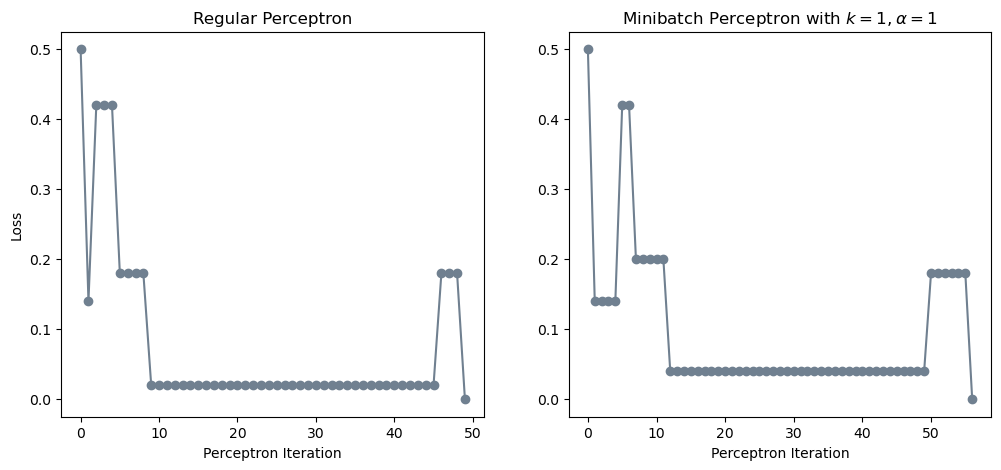

In [42]:
# Fit models
loss_vec, mb_loss_vec, p_w, mb_p_w = experiment(X = X_ls, y = y_ls, k = 1, alpha = 1)

# Create plots
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(loss_vec, color = "slategrey")
ax[0].scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
ax[1].plot(mb_loss_vec, color = "slategrey")
ax[1].scatter(torch.arange(len(mb_loss_vec)), mb_loss_vec, color = "slategrey")

# Add labels 
ax[0].set_title("Regular Perceptron")
ax[1].set_title("Minibatch Perceptron with $k = 1, \\alpha = 1$")
ax[0].set_xlabel("Perceptron Iteration")
ax[0].set_ylabel("Loss")
ax[1].set_xlabel("Perceptron Iteration");

The two algorithms produce similar results. Although in the MiniBatch algorithm it appears as though it takes a few more iterations to converge to a solution with zero loss, if the random point considered at every iteration had been the same, the MiniBatch algorithm would have converged in the same number of iterations as the Perceptron algorithm. 

For the normal Perceptron algorithm we generate a random number between 0 and $n$ but for the MiniBatch perceptron algorithm we generate a random permutation of the numbers $0$ through $n$ - 1 and then iterate through the list of numbers. This is why the MiniBatch perceptron algorithm appears to take longer to converge.

# Part C2: $k$ = 10

In this experiment we will test the MiniBatch Perceptron algorithm with $k=10$ and $\alpha=1$. This means that the MiniBatch Perceptron algorithm will update the weights and bias term based on a mini-batch of 10 data points in each iteration. This can lead to faster convergence and better generalization performance, especially when the training data is large. Let's see:

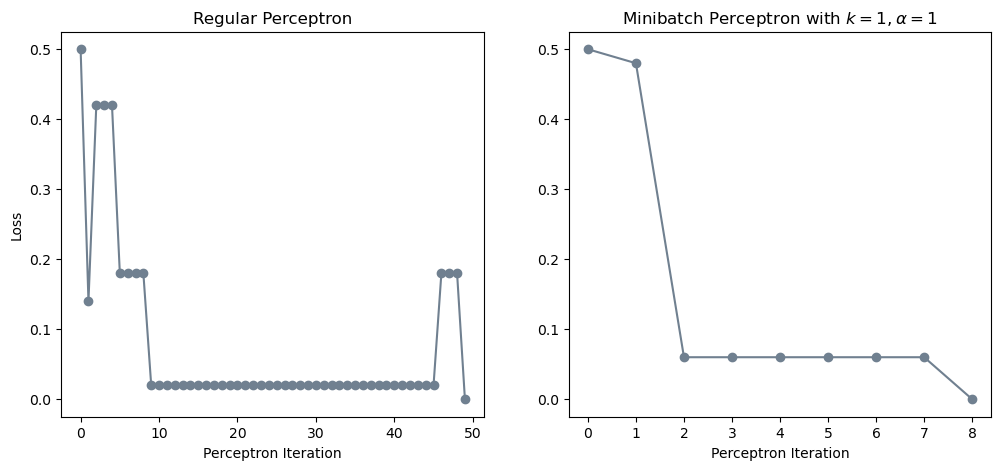

In [46]:
# Fit models
loss_vec, mb_loss_vec, p_w, mb_p_w = experiment(X = X_ls, y = y_ls, k = 10, alpha = 1)

# Create plots
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(loss_vec, color = "slategrey")
ax[0].scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
ax[1].plot(mb_loss_vec, color = "slategrey")
ax[1].scatter(torch.arange(len(mb_loss_vec)), mb_loss_vec, color = "slategrey")

# Add labels 
ax[0].set_title("Regular Perceptron")
ax[1].set_title("Minibatch Perceptron with $k = 1, \\alpha = 1$")
ax[0].set_xlabel("Perceptron Iteration")
ax[0].set_ylabel("Loss")
ax[1].set_xlabel("Perceptron Iteration");

After adjusting our $k$ parameter to 10, we can see that the MiniBatch Perceptron algorithm converges to a solution with zero loss after 8 iterations. This is faster than the Perceptron algorithm, which took 49 iterations to converge to a solution with zero loss. This demonstrates that the MiniBatch Perceptron algorithm can converge faster than the Perceptron algorithm by updating the weights and bias term based on a mini-batch of data points in each iteration.

# Part C3: $k$ = n

In this experiment we will test the MiniBatch Perceptron algorithm with $k=n$ meaning that the batch size is the size of the entire dataset. We can want to show that the MiniBatch Perceptron algorithm can converge even when the data is not linearly separable. Let's see:

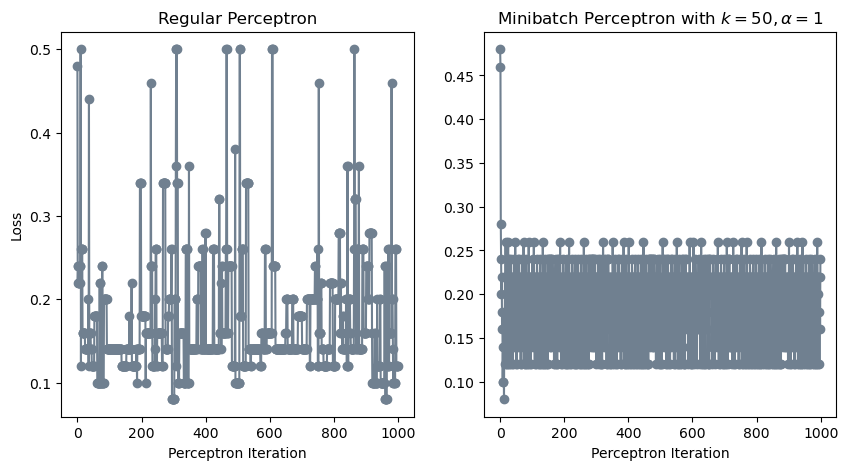

In [47]:
# Fit models
loss_vec, mb_loss_vec, p_w, mb_p_w = experiment(X = X_nls, y = y_nls, k = 50, alpha = 1)

# Create plots
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].plot(loss_vec, color = "slategrey")
ax[0].scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
ax[1].plot(mb_loss_vec, color = "slategrey")
ax[1].scatter(torch.arange(len(mb_loss_vec)), mb_loss_vec, color = "slategrey")

# Add labels
ax[0].set_title("Regular Perceptron")
ax[1].set_title("Minibatch Perceptron with $k = 50, \\alpha = 1$")
ax[0].set_xlabel("Perceptron Iteration")
ax[0].set_ylabel("Loss")
ax[1].set_xlabel("Perceptron Iteration");

Hm, we see that when our $\alpha$ is set to 1, the MiniBatch Perceptron algorithm does not converge to a solution with zero loss. This is because the data is not linearly separable, and the MiniBatch Perceptron algorithm is not able to find a decision boundary that perfectly separates the data points into two classes. 

However, when we set $\alpha$ to 0.1, the MiniBatch Perceptron algorithm should perform a bit better. Let's see:

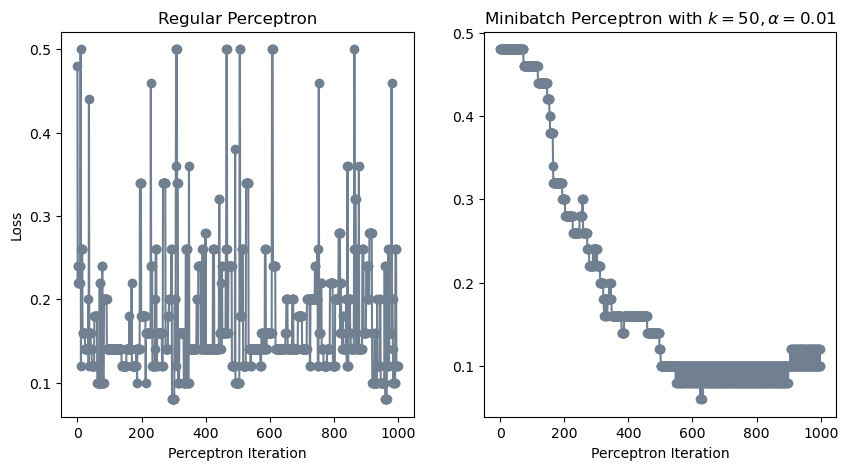

In [48]:
# Fit models
loss_vec, mb_loss_vec, p_w, mb_p_w = experiment(X = X_nls, y = y_nls, k = 50, alpha = 0.01)

# Create plots
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].plot(loss_vec, color = "slategrey")
ax[0].scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
ax[1].plot(mb_loss_vec, color = "slategrey")
ax[1].scatter(torch.arange(len(mb_loss_vec)), mb_loss_vec, color = "slategrey")

# Add labels
ax[0].set_title("Regular Perceptron")
ax[1].set_title("Minibatch Perceptron with $k = 50, \\alpha = 0.01$")
ax[0].set_xlabel("Perceptron Iteration")
ax[0].set_ylabel("Loss")
ax[1].set_xlabel("Perceptron Iteration");

Although the MiniBatch algorithm did not converge to zero loss, it did perform better than the Perceptron algorithm. Compared to the Perceptron algorithm, the MiniBatch algorithm was able to achieve a lower loss value and a higher training accuracy in later iterations instead of jumping around constantly as seen in the normal Perceptron algorithm.

Let's see how well of a job it did for our final decision boundary:

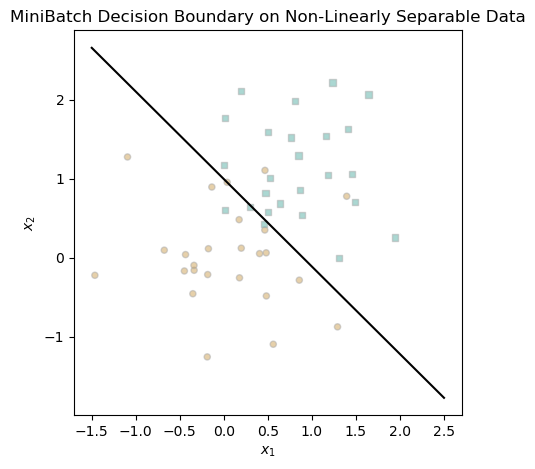

In [49]:
# Plot final decision boundary
fig, ax = plt.subplots(figsize = (5, 5))
plot_perceptron_data(X_nls, y_nls, ax)
draw_line(mb_p_w, x_min = -1.5, x_max = 2.5, ax = ax, color = "black")
# ax.set(xlim = (-1, 2), ylim = (-1, 2))
ax.set_title("MiniBatch Decision Boundary on Non-Linearly Separable Data");

The decision boundary looks pretty good. Obviously, it is not perfect, but it does a reasonable job of separating the data points into two classes. This demonstrates that the MiniBatch Perceptron algorithm can perform better than the Perceptron algorithm on non-linearly separable data by updating the weights and bias term based on a mini-batch of data points in each iteration.

## Part D: Runtime Implications 

In this section, we will discuss the runtime implications of the Perceptron and MiniBatch Perceptron algorithms. 

When considering the runtime implications of the Perceptron and MiniBatch Perceptron algorithms, we need to evaluate the runtime complexity of `opt.step(X,y)` 

Let's first go over `perceptron,py`. `opt.step()` involves the following line by line:

- `n = X.size()[0]`  Determines the amount of rows in **Constant** time
- `i = torch.randint(n, size = (1,))` Selects a random number between 0 and $n$ in **Constant** time
- `x_i = X[[i],:]` and `y_i = y[i]` Creates subsets of the data in **Constant** time
- `current_loss = self.model.loss(X, y)` Calculates the current loss using dot product in **Linear** time
- `self.model.w += torch.reshape(self.model.grad(x_i, y_i),(self.model.w.size()[0],))` Updates the weights in **Linear** time
- ` new_loss = self.model.loss(X, y)` Calculates the new loss in **Linear** time through dot product 
- ` return i, abs(current_loss - new_loss)` Returns the index and the difference in loss in **Constant** time

Since the largest time complexity is **Linear**, we can say that the time complexity of `opt.step()` is **Linear** or $O(n)$.

Now let's go over `minibatch_perceptron.py`. `opt.step()`

The two are actually very similar, the only difference in runtime is in the `grad()` function. In the normal Perceptron algorithm, the `grad()` function is called on a single data point, while in the MiniBatch Perceptron algorithm, the `grad()` function is called on a mini-batch of data points. This means in the normal Perceptron algorithm, a single dot product between 1 x $p$ vectors is computed whereas in the MiniBatch perceptron algorithm a matrix product between $X^{k \times p}$ and $w^{p \times 1}$ is computed. Calculating the matrix product is equal to calculating $k$ dot products, which are both $O(p)$ operations. Meaning that the runtime of the Matrix product is $O(k \cdot p)$.



## Conclusion

In this blog post, I have implemented the Perceptron algorithm from scratch and tested it on a synthetic dataset. I have also implemented the MiniBatch Perceptron algorithm and tested it on different datasets. I have shown that the Perceptron algorithm can learn a decision boundary that separates the data points into two classes, and that the MiniBatch Perceptron algorithm can converge faster than the Perceptron algorithm by updating the weights and bias term based on a mini-batch of data points in each iteration. I have also discussed the runtime implications of the Perceptron and MiniBatch Perceptron algorithms, and shown that the time complexity of the `opt.step()` function is **Linear** for the normal Perceptron algorithm and $O(k \cdot p)$ for the MiniBatch algorithm. Overall, the Perceptron and MiniBatch Perceptron algorithms are simple and efficient algorithms for binary classification tasks, and can be extended to handle data with more than two dimensions. It was great to be able to implement a simple machine learning algorithm from scratch and experiment with it on different datasets. I hope you enjoyed reading this blog post and learned something new about the Perceptron and MiniBatch Perceptron algorithms. Thank you for reading!